# Bidirection Compression


## 1. Implement an environment that would emulate the communication of workers with the server


In [67]:
import time
import numpy as np
from sklearn.utils import gen_batches
import abc


class ServerToWorkerCompressor(metaclass=abc.ABCMeta):
    def __init__(self, compression_ratio):
        self.compression_ratio = compression_ratio
        self.transmitted_coordinates = 0

    @abc.abstractmethod
    def compress(self, X, y):
        pass

    @abc.abstractmethod
    def decompress(self, X, y):
        pass


class WorkerToServerCompressor(metaclass=abc.ABCMeta):
    def __init__(self, compression_ratio):
        self.compression_ratio = compression_ratio
        self.transmitted_coordinates = 0

    @abc.abstractmethod
    def compress(self, gradient_device):
        pass

    def decompress(self, gradient_device, selected_indices, original_size):
        decompressed = np.zeros(original_size)
        decompressed[selected_indices] = gradient_device
        return decompressed

    def omega(self, gradient_device):
        k = max(1, int(len(gradient_device) * self.compression_ratio))
        return len(gradient_device) / k - 1


class NoopServerToWorkerCompressor(ServerToWorkerCompressor):
    def __init__(self):
        super().__init__(0)

    def compress(self, X, y):
        self.transmitted_coordinates += X.shape[0] * X.shape[1] + y.shape[0]
        return X, y

    def decompress(self, X, y):
        return X, y


class DistributedEnvSimulator:
    def __init__(
        self,
        nabla_f,
        gamma_k,
        worker_to_server_compressor,
        server_to_worker_compressor=NoopServerToWorkerCompressor(),
    ):
        self.nabla_f = nabla_f
        self.gamma_k = gamma_k
        self.worker_to_server_compressor = worker_to_server_compressor
        self.server_to_worker_compressor = server_to_worker_compressor

    def simulate_distributed_env(
        self,
        X,
        y,
        n_devices,
        num_iterations=100,
        eps=None,
    ):
        n_features = X.shape[1]
        weights = np.zeros(n_features)
        device_weights = [np.zeros(n_features) for _ in range(n_devices)]
        convergence = []
        accuracies = []
        execution_time = 0

        L = np.sum(np.linalg.vector_norm(X, axis=1) ** 2) / (4 * X.shape[1])
        X_split, y_split = self._split_data(X, y, int(X.shape[0] / n_devices))

        for iteration in range(num_iterations):
            start_time = time.time()
            aggregated_gradient = np.zeros(n_features)

            for _ in range(n_devices):
                device_idx = np.random.randint(0, n_devices)

                X_device = X_split[device_idx]
                y_device = y_split[device_idx]
                weights_device = device_weights[device_idx]

                X_compressed, y_compressed = self.server_to_worker_compressor.compress(X_device, y_device)

                compressed_gradient, indices = self._execute_on_device(
                    X_compressed,
                    y_compressed,
                    weights_device,
                    L,
                )

                aggregated_gradient += self.worker_to_server_compressor.decompress(
                    compressed_gradient, indices, n_features
                )

            gamma = self.gamma_k(L, self.worker_to_server_compressor.omega(aggregated_gradient), n_devices, iteration)
            weights -= gamma * (aggregated_gradient / n_devices)
            execution_time += time.time() - start_time

            accuracy_i = self._estimate_accuracy(X, y, weights)
            accuracies.append(accuracy_i)
            convergence_i = self._estimate_convergence(aggregated_gradient, n_devices)
            convergence.append(convergence_i)

            if eps is not None and accuracy_i < eps:
                break

        transmitted_coordinates_worker_to_server = self.worker_to_server_compressor.transmitted_coordinates
        transmitted_coordinates_server_to_worker = self.server_to_worker_compressor.transmitted_coordinates

        return (
            weights,
            convergence,
            accuracies,
            execution_time,
            transmitted_coordinates_worker_to_server,
            transmitted_coordinates_server_to_worker,
        )

    def _estimate_accuracy(self, X, y, weights):
        y_pred = np.sign(np.dot(X, weights))
        diff = y.astype("int") - y_pred.astype("int")
        false_predictions = len(diff[diff != 0])
        accuracy = 1 - false_predictions / len(y_pred)
        return accuracy

    def _estimate_convergence(self, aggregated_gradient, n_devices):
        return np.linalg.norm(aggregated_gradient / n_devices)

    def _execute_on_device(self, X_compressed, y_compressed, weights, L):
        X, y = self.server_to_worker_compressor.decompress(X_compressed, y_compressed)

        lambda_reg = L / 1000
        gradient_device = self.nabla_f(X, y, weights, lambda_reg)

        compressed_gradient, indices = self.worker_to_server_compressor.compress(gradient_device)

        return compressed_gradient, indices

    def _split_data(self, X, y, batch_size):
        X_batched = []
        y_batched = []
        for batch_indices in gen_batches(n=len(X), batch_size=batch_size, min_batch_size=batch_size):
            X_batched.append(X[batch_indices])
            y_batched.append(y[batch_indices])
        return X_batched, y_batched

## 2. Implement CGD

In [68]:
class RandKWorkerToServerCompressor(WorkerToServerCompressor):
    def compress(self, vector):
        k = max(1, int(len(vector) * self.compression_ratio))

        selected_indices = np.random.choice(len(vector), size=k, replace=False)

        compressed = np.zeros(len(selected_indices))
        compressed = vector[selected_indices]

        self.transmitted_coordinates += len(compressed)

        return compressed, selected_indices

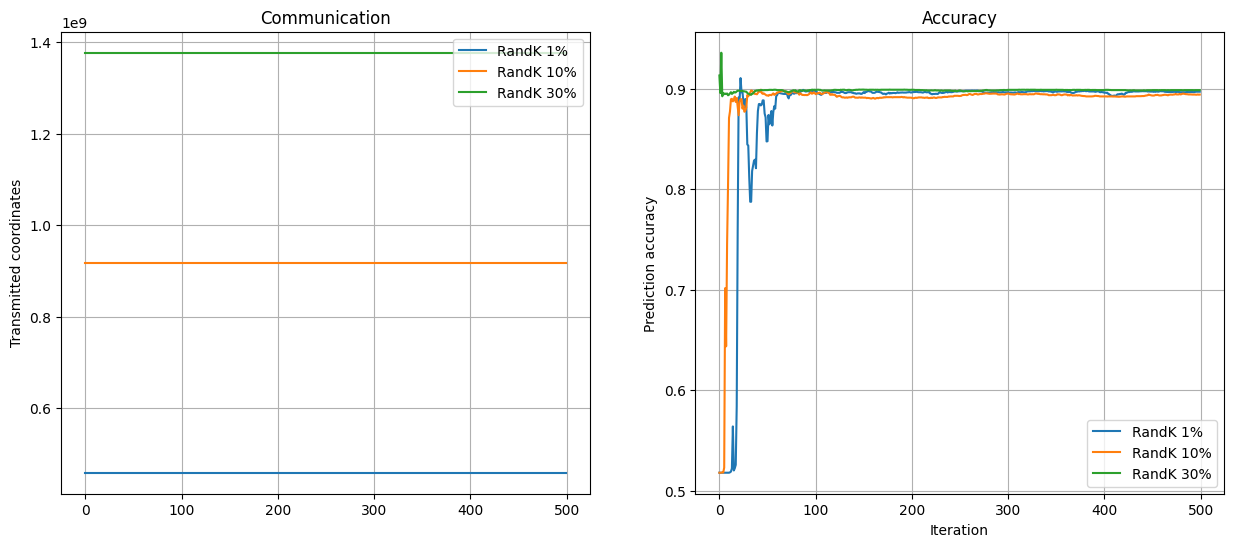

In [69]:
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

n_devices = 10
compression_ratios = [0.01, 0.10, 0.30]
num_iterations = 500


def nabla_f(X, y, w, lambda_reg):
    ratio = -y / (1 + np.exp(y * (X @ w)))
    gradient = np.mean(ratio.reshape(-1, 1) * X, axis=0) + lambda_reg * w
    return gradient / X.shape[1]


def gamma_k(L, omega, n_devices, iteration):
    return 1 / (L * (2 * omega / n_devices + 1))


plt.figure(figsize=(15, 6))

for ratio in compression_ratios:
    randk_worker_to_server_compressor = RandKWorkerToServerCompressor(ratio)
    randk_simulator = DistributedEnvSimulator(
        nabla_f=nabla_f,
        gamma_k=gamma_k,
        worker_to_server_compressor=randk_worker_to_server_compressor,
    )
    (
        randk_weights,
        randk_convergence,
        randk_accuracies,
        randk_execution_time,
        randk_transmitted_coordinates_worker_to_server,
        randk_transmitted_coordinates_server_to_worker,
    ) = randk_simulator.simulate_distributed_env(
        X=X,
        y=y,
        n_devices=n_devices,
        num_iterations=num_iterations,
    )

    plt.subplot(1, 2, 1)
    plt.plot(
        np.full(
            len(randk_accuracies),
            randk_transmitted_coordinates_server_to_worker + randk_transmitted_coordinates_worker_to_server,
        ),
        label=f"RandK {int(ratio*100)}%",
    )

    plt.subplot(1, 2, 2)
    plt.plot(np.array(randk_accuracies), label=f"RandK {int(ratio*100)}%")

plt.subplot(1, 2, 1)
plt.ylabel("Transmitted coordinates")
plt.grid(True)
plt.legend()
plt.title("Communication")

plt.subplot(1, 2, 2)
plt.xlabel("Iteration")
plt.ylabel("Prediction accuracy")
plt.grid(True)
plt.legend()
plt.title("Accuracy")

plt.show()